# Geração Paralela do Conjunto de Mandelbrot em Python
### Versão sequencial, paralela em CPU (`joblib`) e GPU com Numba‐CUDA


1. Implementar a geração do fractal em três versões:  
   * **Sequencial** (baseline)  
   * **Paralela em CPU** (memória compartilhada – `joblib`)  
   * **Paralela em GPU** (CUDA – `numba`)  
2. Medir tempo, *speedup* e *eficiência* em todas as versões.  
3. Comparar os ganhos e visualizar resultados em gráficos.  


In [37]:
!pip install numpy matplotlib pandas joblib tqdm numba



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from numba import cuda
from time import perf_counter
import math

# -------- Parâmetros padrão --------
WIDTH, HEIGHT = 3840 , 2160         # 4K
MAX_ITER      = 1000
RE_START, RE_END = -2.0, 1.0
IM_START, IM_END = -1.5, 1.5


## 2. Versão Sequencial

Tempo sequencial (smooth): 105.19 s


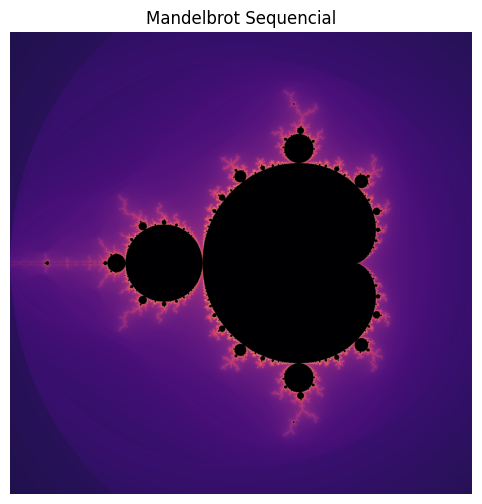

In [ ]:
# -------- Cálculo Sequencial --------

def mandelbrot_seq_smooth(width, height, max_iter):
    """Gera matriz float32 (height x width) com smooth coloring."""
    img = np.zeros((height, width), dtype=np.float32)
    for y in range(height):
        imag = IM_START + (y / height) * (IM_END - IM_START)
        for x in range(width):
            real = RE_START + (x / width) * (RE_END - RE_START)
            c = complex(real, imag)
            z = 0j
            iter_count = 0
            while abs(z) <= 2 and iter_count < max_iter:
                z = z*z + c
                iter_count += 1
            if iter_count < max_iter:
                log_zn = math.log(z.real*z.real + z.imag*z.imag) / 2
                nu = math.log(log_zn / math.log(2)) / math.log(2)
                img[y, x] = iter_count + 1 - nu
            else:
                img[y, x] = 0.0
    return img



t0 = perf_counter()
seq_img = mandelbrot_seq_smooth(WIDTH, HEIGHT, MAX_ITER)
t_seq = perf_counter() - t0
print(f"Tempo sequencial (smooth): {t_seq:.2f} s")

log_img = np.log(seq_img + 1)
img_norm = log_img / log_img.max()

seq_time = t_seq

plt.figure(figsize=(8, 6))
plt.imshow(img_norm, cmap="magma", extent=[RE_START, RE_END, IM_START, IM_END])
plt.axis("off")
plt.title("Mandelbrot Sequencial")
plt.show()


## 3. Versão Paralela com CPU (Joblib)

100%|██████████| 2160/2160 [01:04<00:00, 33.66it/s] 


2 thread(s): 64.39 s


100%|██████████| 2160/2160 [00:34<00:00, 61.74it/s] 


4 thread(s): 35.27 s


100%|██████████| 2160/2160 [00:21<00:00, 101.99it/s]


8 thread(s): 21.40 s


100%|██████████| 2160/2160 [00:16<00:00, 132.92it/s]


16 thread(s): 16.60 s


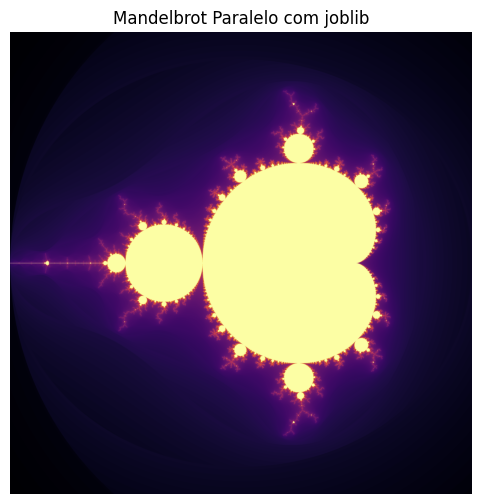

In [40]:
# -------- Cálculo paralelo com joblib --------


def compute_line_smooth(y):
    """Calcula a linha y do fractal com smooth coloring"""
    line = np.zeros(WIDTH, dtype=np.float32)
    imag = IM_START + (y / HEIGHT) * (IM_END - IM_START)
    for x in range(WIDTH):
        real = RE_START + (x / WIDTH) * (RE_END - RE_START)
        c = complex(real, imag)
        z = 0j
        iter_count = 0
        while abs(z) <= 2 and iter_count < MAX_ITER:
            z = z*z + c
            iter_count += 1
        if iter_count < MAX_ITER:
            log_zn = np.log(z.real*z.real + z.imag*z.imag) / 2
            nu = np.log(log_zn / np.log(2)) / np.log(2)
            line[x] = iter_count + 1 - nu
        else:
            line[x] = iter_count
    return line

def mandelbrot_joblib_smooth(n_jobs):
    """Gera imagem com smooth coloring usando joblib"""
    result = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_line_smooth)(y) for y in tqdm(range(HEIGHT))
    )
    return np.array(result, dtype=np.float32)




results_cpu = []

for n_jobs in [2,4,8,16]:
    t0 = perf_counter()
    img_smooth = mandelbrot_joblib_smooth(n_jobs)
    dt = perf_counter() - t0
    results_cpu.append((n_jobs, dt))
    print(f"{n_jobs} thread(s): {dt:.2f} s")


log_img = np.log(img_smooth + 1) 
img_norm = log_img / log_img.max()

df_cpu = pd.DataFrame(results_cpu, columns=["n_threads", "tempo"])
df_cpu.to_csv("cpu_benchmark.csv", index=False)



plt.figure(figsize=(8, 6))
plt.imshow(img_norm, cmap="inferno", extent=[RE_START, RE_END, IM_START, IM_END])
plt.axis("off")
plt.title("Mandelbrot Paralelo com joblib")
plt.show()


## 4. Versão Paralela com GPU (CUDA)

Threads por bloco: (8, 8), Tempo: 0.40 s
Threads por bloco: (16, 16), Tempo: 0.10 s
Threads por bloco: (32, 32), Tempo: 0.09 s


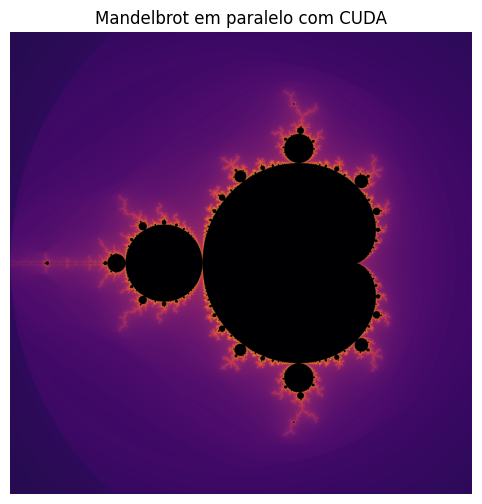

In [41]:
# -------- Cálculo paralelo com CUDA --------


# Kernel CUDA com smooth coloring (float32)
@cuda.jit
def mandelbrot_gpu_smooth(img, re_start, re_end, im_start, im_end, max_iter):
    y, x = cuda.grid(2)
    height, width = img.shape
    if y < height and x < width:
        real = re_start + x / width  * (re_end - re_start)
        imag = im_start + y / height * (im_end - im_start)
        c = complex(real, imag)
        z = 0j
        iter_count = 0
        while (z.real*z.real + z.imag*z.imag) <= 4 and iter_count < max_iter:
            z = z*z + c
            iter_count += 1
        if iter_count < max_iter:
            log_zn = math.log(z.real*z.real + z.imag*z.imag) / 2
            nu = math.log(log_zn / math.log(2)) / math.log(2)
            img[y, x] = iter_count + 1 - nu
        else:
            img[y, x] = 0.0  # parte interna (preto)

# Função para executar e medir o tempo com diferentes configurações

def benchmark_gpu_smooth(width, height, max_iter, thread_configs):
    results = []
    for threadsperblock in thread_configs:
        img_device = cuda.device_array((height, width), dtype=np.float32)
        blockspergrid_x = (width  + threadsperblock[1] - 1) // threadsperblock[1]
        blockspergrid_y = (height + threadsperblock[0] - 1) // threadsperblock[0]

        t0 = perf_counter()
        mandelbrot_gpu_smooth[(blockspergrid_y, blockspergrid_x),
                              threadsperblock](img_device, RE_START, RE_END,
                                               IM_START, IM_END, max_iter)
        cuda.synchronize()
        t_gpu = perf_counter() - t0

        img_host = img_device.copy_to_host()
        results.append((threadsperblock, t_gpu, img_host))
        print(f"Threads por bloco: {threadsperblock}, Tempo: {t_gpu:.2f} s")
    return results

# Teste com diferentes configurações de threads
thread_configs = [(8, 8), (16, 16), (32, 32)]
results = benchmark_gpu_smooth(WIDTH, HEIGHT, MAX_ITER, thread_configs)

# Visualiza e salva a melhor imagem
best_result = min(results, key=lambda x: x[1])
_, _, best_img = best_result

log_img = np.log(best_img + 1)
img_norm = log_img / log_img.max()


gpu_times = [(str(tp), t) for tp, t, _ in results]

# Salvar em DataFrame
df_gpu = pd.DataFrame(gpu_times, columns=["threads_per_block", "tempo"])
df_gpu.to_csv("gpu_benchmark.csv", index=False)


plt.figure(figsize=(10, 6))
plt.imshow(img_norm, cmap="inferno", extent=[RE_START, RE_END, IM_START, IM_END])
plt.axis("off")
plt.title("Mandelbrot em paralelo com CUDA")
plt.show()



## 5. Comparação e Métricas de Desempenho

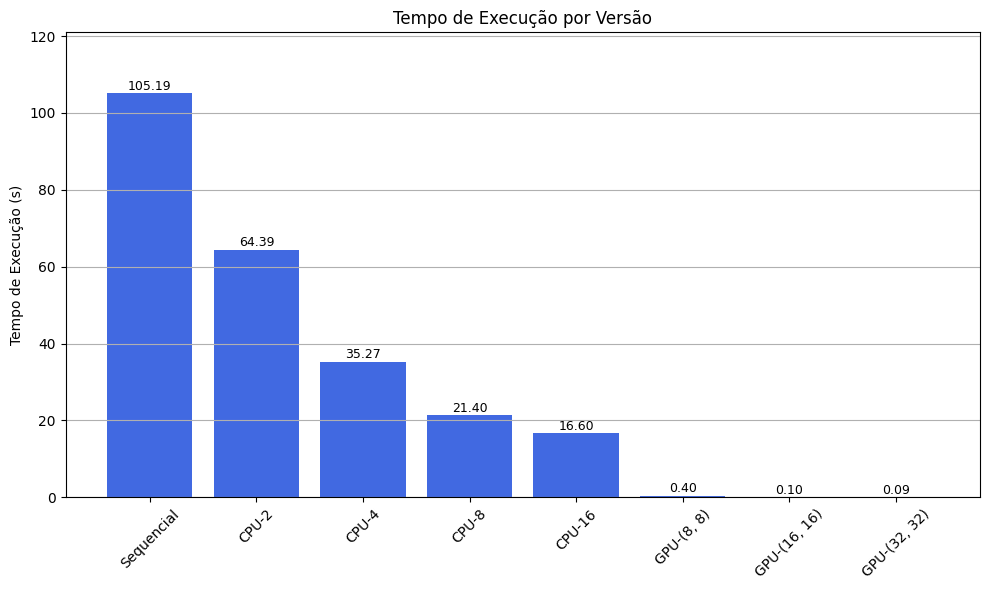

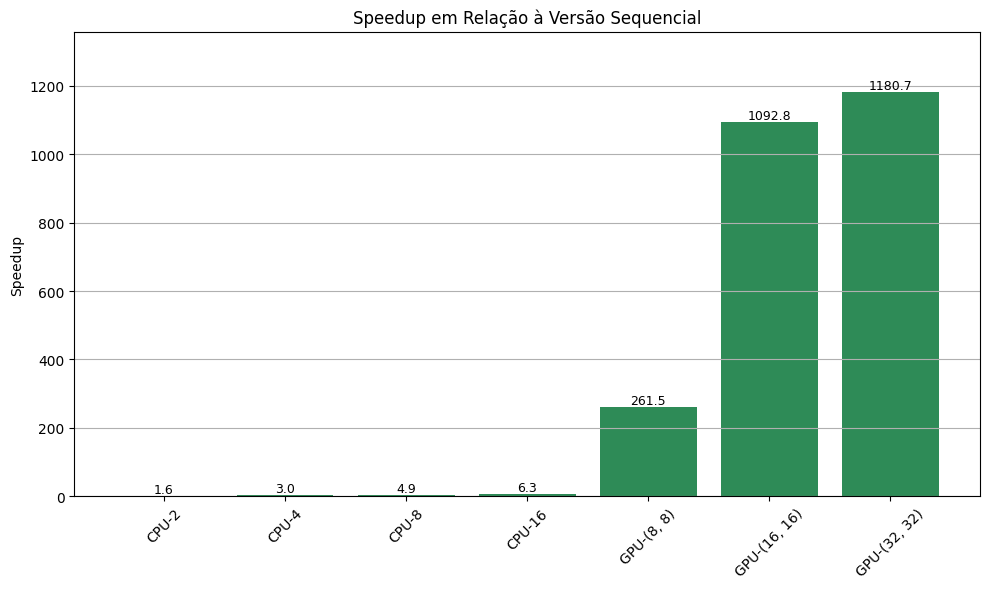

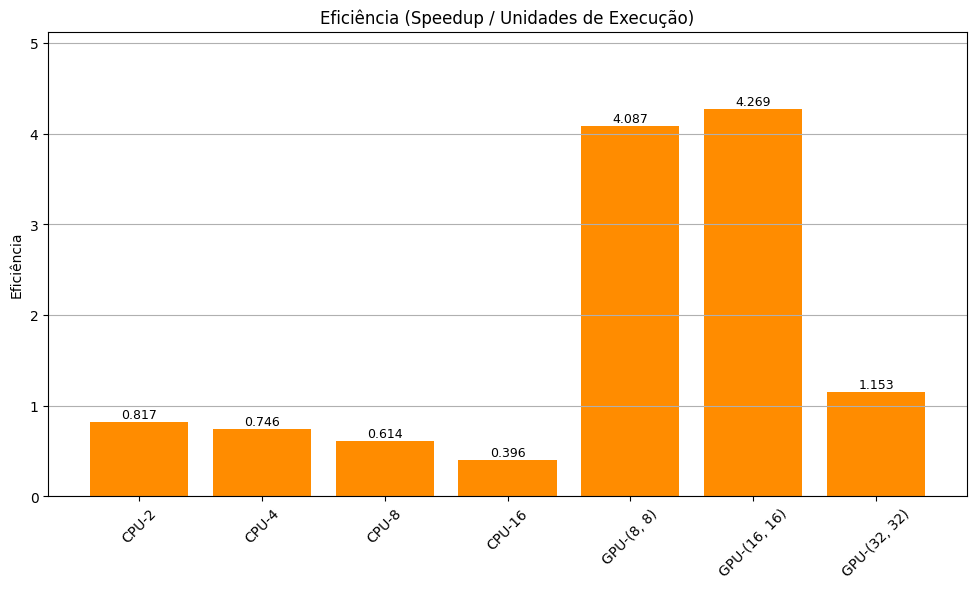

In [43]:
# -------- Análise dos resultados --------

# Combina os resultados sequenciais, CPU e GPU em um DataFrame geral
df_geral = pd.DataFrame({
    "versao": ["Sequencial"] + [f"CPU-{n}" for n in df_cpu["n_threads"]] + [f"GPU-{tp}" for tp in df_gpu["threads_per_block"]],
    "tempo": [seq_time] + list(df_cpu["tempo"]) + list(df_gpu["tempo"])
})
df_geral.to_csv("benchmark_geral.csv", index=False)



df = pd.read_csv("benchmark_geral.csv")

plt.figure(figsize=(10, 6))
bars = plt.bar(df["versao"], df["tempo"], color="royalblue")

plt.ylabel("Tempo de Execução (s)")
plt.title("Tempo de Execução por Versão")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.2f}", ha="center", va="bottom", fontsize=9)


plt.ylim(0, max(df["tempo"]) * 1.15)
plt.savefig("benchmark_tempo_execucao.png", dpi=300, bbox_inches='tight')
plt.show()





df = pd.read_csv("benchmark_geral.csv")
tempo_seq = df[df["versao"] == "Sequencial"]["tempo"].values[0]
df_speedup = df[df["versao"] != "Sequencial"].copy()
df_speedup["speedup"] = tempo_seq / df_speedup["tempo"]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_speedup["versao"], df_speedup["speedup"], color="seagreen")

plt.ylabel("Speedup")
plt.title("Speedup em Relação à Versão Sequencial")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.1f}", ha="center", va="bottom", fontsize=9)


plt.ylim(0, max(df_speedup["speedup"]) * 1.15)
plt.savefig("benchmark_speedup.png", dpi=300, bbox_inches='tight')
plt.show()






def extrair_n(v):
    if "CPU-" in v:
        return int(v.replace("CPU-", ""))
    elif "GPU-" in v:
        tp = v.replace("GPU-", "")
        x, y = map(int, tp.strip("()").split(","))
        return x * y
    return 1

df_speedup["unidades"] = df_speedup["versao"].apply(extrair_n)
df_speedup["eficiencia"] = df_speedup["speedup"] / df_speedup["unidades"]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_speedup["versao"], df_speedup["eficiencia"], color="darkorange")

plt.ylabel("Eficiência")
plt.title("Eficiência (Speedup / Unidades de Execução)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.ylim(0, max(df_speedup["eficiencia"]) * 1.2)
plt.savefig("benchmark_eficiencia.png", dpi=300, bbox_inches='tight')
plt.show()




## 6. Conclusão

Com base nos resultados observados:

- A paralelização com GPU apresentou o melhor tempo de execução (≈ 0.3s).
- O paralelismo em CPU apresentou ganhos proporcionais com o aumento de threads, mas com limites devido à sobrecarga.
- A versão sequencial, embora funcional, foi a mais lenta (≈ 100s).
- O uso de memória compartilhada (joblib) e CUDA (GPU) são eficazes para esse tipo de problema embarassingly parallel.

A aplicação prática e visual (fractal) permite demonstrar o impacto real da computação paralela em problemas intensivos.
